In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from astropy.table import Table, unique, Column, hstack, vstack
from xdgmm import XDGMM

In [4]:
datahigh = Table.read('dustHighLat-result.fits.gz')
datalow = Table.read('dustLowLat-result.fits.gz')

In [5]:
data = vstack((datahigh, datalow))

In [5]:
len(data)

25496246

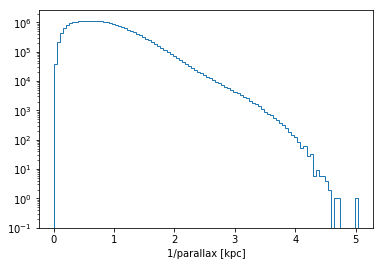

In [6]:
plt.hist(1./data['parallax'], bins=100, log=True, histtype='step');
plt.xlabel('1/parallax [kpc]')

In [7]:
ncomp = 256
xdgmm = XDGMM(filename='rjce_lowdust_{0}G.fits'.format(ncomp))

In [8]:
absmag = data['w2mpro'] - 5.*np.log10(1./(data['parallax']/1e2))
color = data['h_m'] - data['w2mpro']
colorErr = np.sqrt(data['h_msigcom']**2 + data['w2mpro_error']**2.)
absmagErr = data['w2mpro_error']

In [9]:
sample = xdgmm.sample(len(data))

In [10]:
def plotXdgmm(xdgmm, ax, c='k', lw=1, label='prior', step=0.001):
    ts = np.arange(0, 2. * np.pi, step) #magic
    amps = xdgmm.weights
    mus = xdgmm.mu
    Vs = xdgmm.V
    for gg in range(xdgmm.n_components):
        if amps[gg] == np.max(amps):
            label=label
        else:
            label=None
        w, v = np.linalg.eigh(Vs[gg])
        points = np.sqrt(w[0]) * (v[:, 0])[:,None] * (np.cos(ts))[None, :] + \
                 np.sqrt(w[1]) * (v[:, 1])[:,None] * (np.sin(ts))[None, :] + \
                 mus[gg][:, None]
        ax.plot(points[0,:], points[1,:], c, lw=lw, alpha=amps[gg]/np.max(amps), rasterized=True, label=label)

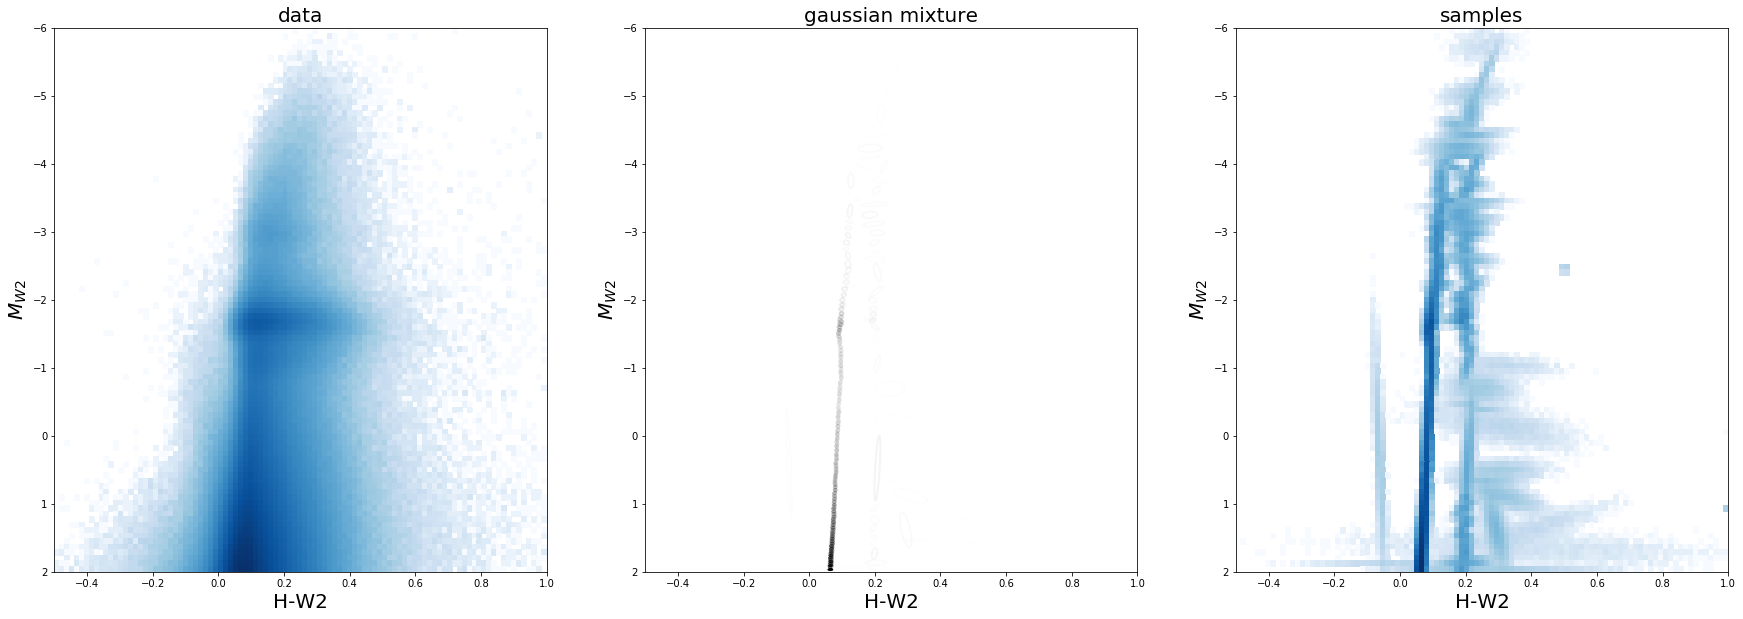

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

xlim = [-0.5, 1.0]
ylim = [-6, 2]
nbins = 100
xbins = np.linspace(xlim[0], xlim[1], nbins)
ybins = np.linspace(ylim[0], ylim[1], nbins)

for c, ab, a in zip([color, sample[:,0]], [absmag, sample[:,1]], [ax[0], ax[2]]):
    H, xe, ye = np.histogram2d(c, 
                           ab, 
                           bins=(xbins, ybins))
    im = a.pcolormesh(xe, ye, H.T,
      norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
    im.set_rasterized(True)

plotXdgmm(xdgmm, ax[1], lw=2)

labels = ['data', 'gaussian mixture', 'samples']

for a , l in zip(ax, labels):
    a.set_xlabel('H-W2', fontsize=20)
    a.set_ylabel('$M_{W2}$', fontsize=20)
    a.set_xlim(xlim)
    a.set_ylim(ylim[::-1])
    a.set_title(l, fontsize=20)

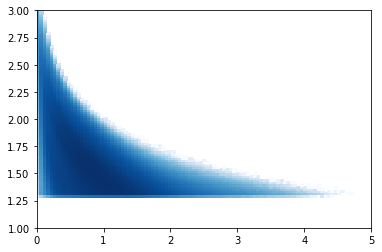

In [10]:
H, xe, ye = np.histogram2d(1./data['parallax'], 
                       np.log10(data['parallax']/data['parallax_error']), 
                       bins=(np.linspace(0, 5, 100), np.linspace(1, 3, 100)))
im = plt.pcolormesh(xe, ye, H.T,
  norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
im.set_rasterized(True)


In [11]:
import scipy.stats as stats

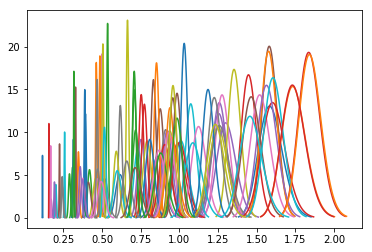

In [16]:
for i in range(100):
    mu = data['parallax'][i]
    sigma = data['parallax_error'][i]
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(1./x, stats.norm.pdf(x, mu, sigma))


## Assumption: uncertainties in absolute magnitude are Gaussian 

yeah


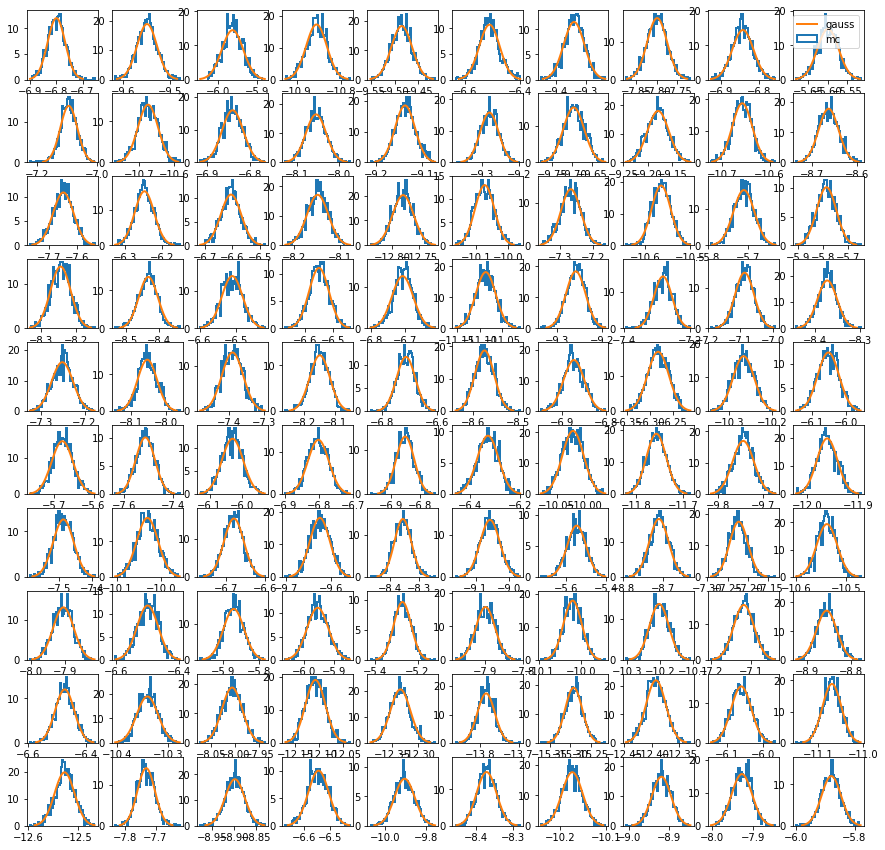

In [64]:
def absMag(appmag, parallax):
    return appmag - 5.*np.log10(1e4*parallax)

fig, ax = plt.subplots(10, 10, figsize=(15, 15))
ax = ax.flatten()
for j in range(100):
    i = np.random.randint(0, len(data))
    appmag_samples = np.random.normal(loc=data['w2mpro'][i], scale=data['w2mpro_error'][i], size=1000)
    parallax_samples = np.random.normal(loc=data['parallax'][i], scale=data['parallax_error'][i], size=1000)
    absmag_samples = absMag(appmag_samples, data['parallax'][i])
    
    absmag = absMag(data['w2mpro'][i], data['parallax'][i])
    absmagError = np.sqrt(data['w2mpro_error'][i]**2. + (5./(10.*np.log(10)))**2.*(data['parallax_error'][i]/data['parallax'][i])**2.)
    mu = absmag
    sigma = absmagError
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

    
    if j == 9:
        labelTrue = 'mc'
        labelGaus = 'gauss'
        print('yeah')
    else:
        labelTrue = None
        labelGaus = None
    ax[j].hist(absmag_samples, histtype='step', normed=True, bins=50, lw=2, label=labelTrue)
    ax[j].plot(x, stats.norm.pdf(x, loc=mu, scale=sigma), lw=2, label=labelGaus)
ax[9].legend(loc='best')

In [66]:
np.min(data['parallax'])

0.19823311532182333

yeah


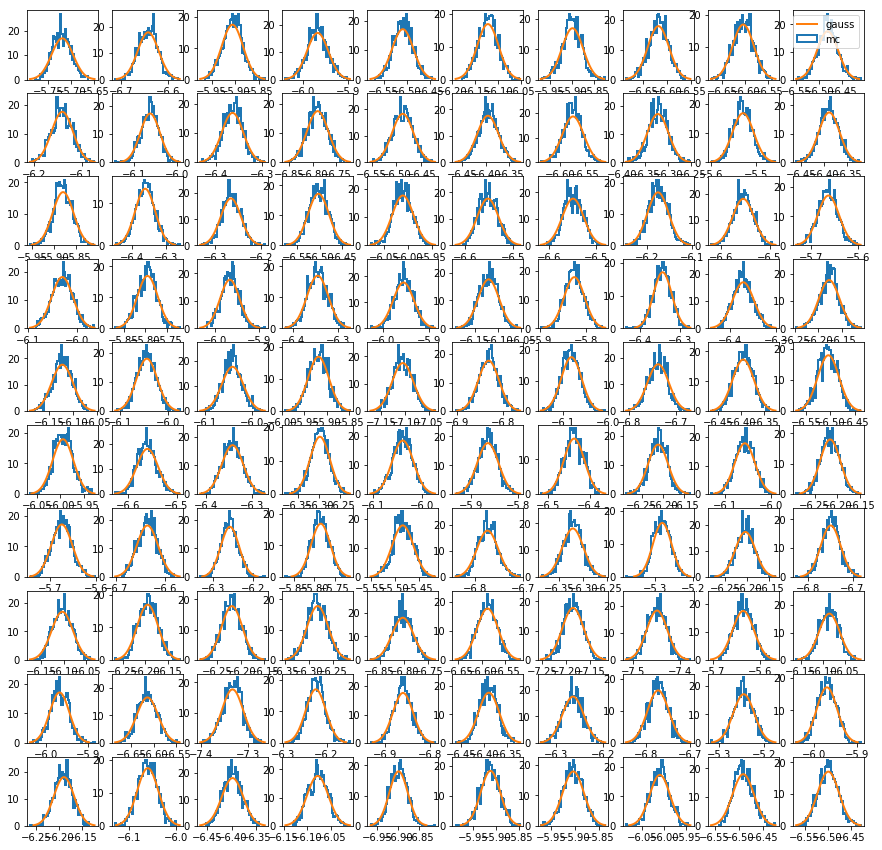

In [67]:
fig, ax = plt.subplots(10, 10, figsize=(15, 15))
ax = ax.flatten()
far = data['parallax'] < 0.3
for j in range(100):
    i = np.random.randint(0, np.sum(far))
    appmag_samples = np.random.normal(loc=data['w2mpro'][far][i], scale=data['w2mpro_error'][far][i], size=1000)
    parallax_samples = np.random.normal(loc=data['parallax'][far][i], scale=data['parallax_error'][far][i], size=1000)
    absmag_samples = absMag(appmag_samples, data['parallax'][far][i])
    
    absmag = absMag(data['w2mpro'][far][i], data['parallax'][far][i])
    absmagError = np.sqrt(data['w2mpro_error'][far][i]**2. + (5./(10.*np.log(10)))**2.*(data['parallax_error'][far][i]/data['parallax'][far][i])**2.)
    mu = absmag
    sigma = absmagError
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

    
    if j == 9:
        labelTrue = 'mc'
        labelGaus = 'gauss'
        print('yeah')
    else:
        labelTrue = None
        labelGaus = None
    ax[j].hist(absmag_samples, histtype='step', normed=True, bins=50, lw=2, label=labelTrue)
    ax[j].plot(x, stats.norm.pdf(x, loc=mu, scale=sigma), lw=2, label=labelGaus)
ax[9].legend(loc='best')

In [65]:
absmagError = np.sqrt(data['w2mpro_error']**2. + (5./(10.*np.log(10)))**2.*(data['parallax_error']/data['parallax'])**2.)

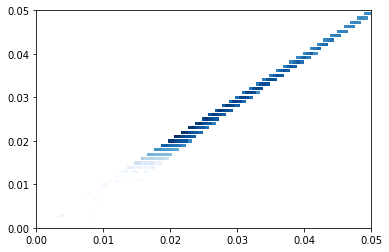

In [28]:
H, xe, ye = np.histogram2d(absmagError, 
                       data['w2mpro_error'], 
                       bins=(np.linspace(0, 0.05, 100), np.linspace(0, 0.05, 100)))
im = plt.pcolormesh(xe, ye, H.T,
  norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
im.set_rasterized(True)


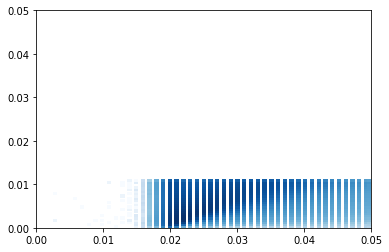

In [29]:
H, xe, ye = np.histogram2d(data['w2mpro_error'], 
                       (5./(10.*np.log(10)))*(data['parallax_error']/data['parallax']), 
                       bins=(np.linspace(0, 0.05, 100), np.linspace(0, 0.05, 100)))
im = plt.pcolormesh(xe, ye, H.T,
  norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
im.set_rasterized(True)


In [ ]:
def obsColor(color, A):
    return color + A/0.918
def obsMag(mag, A):
    return mag + A*0.43